In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import wget
import requests
from bs4 import BeautifulSoup
import re

### Get nasdaq top 100 companies list

In [118]:
#url = "https://www.nasdaq.com/market-activity/quotes/nasdaq-ndx-index"
#r = requests.get(url)
#s = BeautifulSoup(r.text, "lxml")
dfc = pd.read_csv("data/nasdaq_100_mcap_close.csv")
for i in range(len(dfc)):
    dfc.iloc[i]["close"] = dfc.iloc[i]["close"].replace("$", "")
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(", Inc. Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Inc. Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Inc. Class A Capital Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Inc. Class B Capital Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Inc. Class A Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Inc. Class C Capital Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Class A Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Class B Common Stock", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Class A", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Class B", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Class C", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Ordinary Shares", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" Company Ordinary Shares", "") 
    dfc.iloc[i]["name"] = dfc.iloc[i]["name"].replace(" New York Registry Shares", "") 
    dfc.at[i, "market_cap"] = dfc.at[i, "market_cap"].replace(",","")
dfc["close"] = dfc["close"].astype(float)
dfc["market_cap"] = dfc["market_cap"].astype(int)

dfc.head(2)
dfan = pd.read_csv("data/nasdaq_all_companylist.csv")
dfan = dfan[["Symbol", "IPOyear", "Sector", "Industry"]]
dfan.rename(columns={"Symbol":"symbol"}, inplace=True)
dfan.head(2)
dfn100 = dfc.set_index("symbol").join(dfan.set_index("symbol")).reset_index()
dfn100
dfn100_topAuto = dfn100.copy()
dfn100_topAuto["trading_on"] = "NASDAQ"
dfn100_topAuto

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on
0,ATVI,Activision Blizzard,46699438722,60.71,NaN,Technology,Computer Software: Prepackaged Software,NASDAQ
1,ADBE,Adobe,160628689302,332.38,1986.0,Technology,Computer Software: Prepackaged Software,NASDAQ
2,AMD,Advanced Micro Devices,53079240504,45.38,NaN,Technology,Semiconductors,NASDAQ
3,ALXN,Alexion Pharmaceuticals,19669253468,88.84,1996.0,Health Care,Major Pharmaceuticals,NASDAQ
4,ALGN,Align Technology,17968321214,228.16,2001.0,Health Care,Industrial Specialties,NASDAQ
5,GOOG,Alphabet,879994236775,1280.39,2004.0,Technology,"Computer Software: Programming, Data Processing",NASDAQ
6,GOOGL,Alphabet,876406603385,1275.17,NaN,Technology,"Computer Software: Programming, Data Processing",NASDAQ
7,AMZN,Amazon.com,941767754168,1891.82,1997.0,Consumer Services,Catalog/Specialty Distribution,NASDAQ
8,AAL,American Airlines Group,7242998648,17.00,NaN,Transportation,Air Freight/Delivery Services,NASDAQ
9,AMGN,Amgen,121972050169,206.80,1983.0,Health Care,Biotechnology: Biological Products (No Diagnos...,NASDAQ


##### Top Auto manufacturing

In [146]:
dfa = pd.read_csv("data/top_auto_manufacturing.csv")[["Company", "Market cap.", "IPOyear"]]
dfa.rename(columns={"Market cap.":"market_cap"}, inplace=True)
for i in range(len(dfa)):
    if (dfa.iloc[i]["Company"]=="Fiat Chrysler Automobiles… FCAU: NYSE"):
        dfa.at[i, "name"] = "Fiat Chrysler Automobiles"
        dfa.at[i, "symbol"] = "FCAU" 
        dfa.at[i, "trading_on"] = "NYSE"
    elif (dfa.iloc[i]["Company"]=="Volkswagen… VOW3: Other"):
        dfa.at[i, "name"] = "Volkswagen"
        dfa.at[i, "symbol"] = "VOW3"
        dfa.at[i, "trading_on"] = "Other"
    elif (dfa.iloc[i]["Company"]=="Hyundai Motor Company… HYMTF: Other"):
        dfa.at[i, "name"] = "Hyundai"
        dfa.at[i, "symbol"] = "HYMTF" 
        dfa.at[i, "trading_on"] = "Other"
    else:
        dfa.at[i, "name"] = dfa["Company"].iloc[i].split("\xa0")[0]
        dfa.at[i, "symbol"] = dfa["Company"].iloc[i].split("\xa0")[1].split(": ")[0]
        dfa.at[i, "trading_on"] = dfa["Company"].iloc[i].split("\xa0")[1].split(": ")[1]
    
    if (dfa.iloc[i]["market_cap"].split(".")[1][1]=="B"):
        dfa.at[i, "market_cap"] = int(dfa.iloc[i]["market_cap"].split(".")[0])*1e9
    elif (dfa.iloc[i]["market_cap"].split(".")[1][1]=="M"):
        dfa.at[i, "market_cap"] = int(dfa.iloc[i]["market_cap"].split(".")[0])*1e6
    elif (dfa.iloc[i]["market_cap"].split(".")[1][1]=="K"):
        dfa.at[i, "market_cap"] = int(dfa.iloc[i]["market_cap"].split(".")[0])*1e3
    else:
        print("Undefined mcap suffix")
dfa["market_cap"] = dfa["market_cap"].astype(int)
dfa["Sector"] = "Capital Goods"
dfa["Industry"] = "Auto Manufacturing"
dfa["close"] = -1
dfa = dfa[["symbol", "name", "market_cap", "close", "IPOyear", "Sector", "Industry", "trading_on"]]
dfa

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on
0,F,Ford Motor Company,20000000000,-1,1956,Capital Goods,Auto Manufacturing,NYSE
1,GM,General Motors Com...,30000000000,-1,2010,Capital Goods,Auto Manufacturing,NYSE
2,HOG,Harley-Davidson In...,2000000000,-1,1986,Capital Goods,Auto Manufacturing,NYSE
3,HMC,Honda Motor Co Ltd...,42000000000,-1,1978,Capital Goods,Auto Manufacturing,NYSE
4,SPAR,Spartan Motors Inc,433000000,-1,1984,Capital Goods,Auto Manufacturing,NASDAQ
5,TM,Toyota Motor Corp ...,205000000000,-1,1999,Capital Goods,Auto Manufacturing,NYSE
6,DDAIF,Daimler AG,32000000000,-1,1993,Capital Goods,Auto Manufacturing,NYSE
7,NSANY,Nissan Motor Co Lt...,15000000000,-1,1980,Capital Goods,Auto Manufacturing,NASDAQ
8,TTM,Tata Motors Limite...,3000000000,-1,2004,Capital Goods,Auto Manufacturing,NYSE
9,FCAU,Fiat Chrysler Automobiles,14000000000,-1,2014,Capital Goods,Auto Manufacturing,NYSE


#### All companies list

In [148]:
dfac = dfn100_topAuto.append(dfa)
dfac.to_csv("data/all_companies_list.csv", index=False)
dfac

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on
0,ATVI,Activision Blizzard,46699438722,60.71,NaN,Technology,Computer Software: Prepackaged Software,NASDAQ
1,ADBE,Adobe,160628689302,332.38,1986.0,Technology,Computer Software: Prepackaged Software,NASDAQ
2,AMD,Advanced Micro Devices,53079240504,45.38,NaN,Technology,Semiconductors,NASDAQ
3,ALXN,Alexion Pharmaceuticals,19669253468,88.84,1996.0,Health Care,Major Pharmaceuticals,NASDAQ
4,ALGN,Align Technology,17968321214,228.16,2001.0,Health Care,Industrial Specialties,NASDAQ
5,GOOG,Alphabet,879994236775,1280.39,2004.0,Technology,"Computer Software: Programming, Data Processing",NASDAQ
6,GOOGL,Alphabet,876406603385,1275.17,NaN,Technology,"Computer Software: Programming, Data Processing",NASDAQ
7,AMZN,Amazon.com,941767754168,1891.82,1997.0,Consumer Services,Catalog/Specialty Distribution,NASDAQ
8,AAL,American Airlines Group,7242998648,17.00,NaN,Transportation,Air Freight/Delivery Services,NASDAQ
9,AMGN,Amgen,121972050169,206.80,1983.0,Health Care,Biotechnology: Biological Products (No Diagnos...,NASDAQ


### Get company details (Sector, P/E)

In [156]:
#url = "https://www.nasdaq.com/market-activity/stocks/tsla"
#url = "https://www.nasdaq.com/market-activity/stocks/tsla/price-earnings-peg-ratios"
dfac = pd.read_csv("data/all_companies_list.csv")
dfcd = pd.DataFrame(columns=["symbol", "prev_close", "year_low", "year_high", "volume", "beta", "pe_ratio", "eps"])
dfcd.to_csv("data/all_companies_data.csv", index=False)

In [158]:
idx = 0

for i in range(len(dfac)):
    symbol = dfac.iloc[i]["symbol"]
    print(symbol)
    
    url = "https://finance.yahoo.com/quote/"+symbol+"?p="+symbol+"&.tsrc=fin-srch"
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    td_idx = 0

    dfcd.at[idx, "symbol"] = symbol
    while td_idx < len(soup.findAll("td")):
        text = soup.findAll("td")[td_idx].text
        if text=="Previous Close":
            dfcd.at[idx, "prev_close"] = soup.findAll("td")[td_idx+1].text
        elif text=="52 Week Range":
            dfcd.at[idx, "year_low"] = soup.findAll("td")[td_idx+1].text.split(" - ")[0]
            dfcd.at[idx, "year_high"] = soup.findAll("td")[td_idx+1].text.split(" - ")[1]
        elif text=="Volume":
            dfcd.at[idx, "volume"] = soup.findAll("td")[td_idx+1].text
        elif "Beta (5Y Monthly)" in text:
            dfcd.at[idx, "beta"] = soup.findAll("td")[td_idx+1].text
        elif "PE Ratio (TTM)" in text:
            dfcd.at[idx, "pe_ratio"] = soup.findAll("td")[td_idx+1].text
        elif "EPS (TTM)" in text:
            dfcd.at[idx, "eps"] = soup.findAll("td")[td_idx+1].text
        td_idx+=2
        
    if i%10==0:
        dfcd.to_csv("data/all_companies_data.csv", index=False, mode="a", header=False)
    idx+=1
dfcd.to_csv("data/all_companies_data.csv", index=False)

ATVI
ADBE
AMD
ALXN
ALGN
GOOG
GOOGL
AMZN
AAL
AMGN
ADI
ANSS
AAPL
AMAT
ASML
ADSK
ADP
BIDU
BIIB
BMRN
BKNG
AVGO
CDNS
CDW
CERN
CHTR
CHKP
CTAS
CSCO
CTXS
CTSH
CMCSA
CPRT
CSGP
COST
CSX
DLTR
EBAY
EA
EXC
EXPE
FB
FAST
FISV
FOX
FOXA
GILD
IDXX
ILMN
INCY
INTC
INTU
ISRG
JD
KLAC
LRCX
LBTYA
LBTYK
LULU
MAR
MXIM
MELI
MCHP
MU
MSFT
MDLZ
MNST
NTAP
NTES
NFLX
NVDA
NXPI
ORLY
PCAR
PAYX
PYPL
PEP
QCOM
REGN
ROST
SGEN
SIRI
SWKS
SPLK
SBUX
SNPS
TMUS
TTWO
TSLA
TXN
KHC
TCOM
ULTA
UAL
VRSN
VRSK
VRTX
WBA
WDC
WLTW
WDAY
XEL
XLNX
F
GM
HOG
HMC
SPAR
TM
DDAIF
NSANY
TTM
FCAU
VOW3
HYMTF


In [168]:
dfcd = pd.read_csv("data/all_companies_data.csv")
symbol = "VOW3.DE" #dfac.iloc[i]["symbol"]
print(symbol)

url = "https://finance.yahoo.com/quote/"+symbol+"?p="+symbol+"&.tsrc=fin-srch"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
td_idx = 0
idx = dfcd[dfcd["symbol"]=="VOW3"].index.values[0]

dfcd.at[idx, "symbol"] = symbol
while td_idx < len(soup.findAll("td")):
    text = soup.findAll("td")[td_idx].text
    if text=="Previous Close":
        dfcd.at[idx, "prev_close"] = soup.findAll("td")[td_idx+1].text
    elif text=="52 Week Range":
        dfcd.at[idx, "year_low"] = soup.findAll("td")[td_idx+1].text.split(" - ")[0]
        dfcd.at[idx, "year_high"] = soup.findAll("td")[td_idx+1].text.split(" - ")[1]
    elif text=="Volume":
        dfcd.at[idx, "volume"] = soup.findAll("td")[td_idx+1].text
    elif "Beta (5Y Monthly)" in text:
        dfcd.at[idx, "beta"] = soup.findAll("td")[td_idx+1].text
    elif "PE Ratio (TTM)" in text:
        dfcd.at[idx, "pe_ratio"] = soup.findAll("td")[td_idx+1].text
    elif "EPS (TTM)" in text:
        dfcd.at[idx, "eps"] = soup.findAll("td")[td_idx+1].text
    td_idx+=2
dfcd.to_csv("data/all_companies_data.csv", index=False)

VOW3.DE


#### Combine all data

In [198]:
dfcd = pd.read_csv("data/all_companies_data.csv")
dfcd
dfac = pd.read_csv("data/all_companies_list.csv")
dfac.at[dfac["symbol"]=="VOW3", "symbol"] = "VOW3.DE"
dfad = dfac.set_index("symbol").join(dfcd.set_index("symbol")).reset_index()
for i in range(len(dfad)):
    dfad.at[i, "prev_close"] = dfad.iloc[i]["prev_close"].replace(",","")
    dfad.at[i, "year_low"] = dfad.iloc[i]["year_low"].replace(",","")
    dfad.at[i, "year_high"] = dfad.iloc[i]["year_high"].replace(",","")
    dfad.at[i, "volume"] = dfad.iloc[i]["volume"].replace(",","")

dfad["prev_close"] = dfad["prev_close"].astype(float)
dfad["year_low"] = dfad["year_low"].astype(float)
dfad["year_high"] = dfad["year_high"].astype(float)
dfad["volume"] = dfad["volume"].astype(int)
dfad["beta"] = dfad["beta"].astype(float)
dfad["pe_ratio"] = dfad["pe_ratio"].astype(float)
dfad["eps"] = dfad["eps"].astype(float)

dfad.to_csv("data/all_companies_all_data.csv", index=False)
dfad

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on,prev_close,year_low,year_high,volume,beta,pe_ratio,eps
0,ATVI,Activision Blizzard,46699438722,60.71,NaN,Technology,Computer Software: Prepackaged Software,NASDAQ,58.47,41.84,64.53,10128828,0.76,30.50,1.950
1,ADBE,Adobe,160628689302,332.38,1986.0,Technology,Computer Software: Prepackaged Software,NASDAQ,318.39,255.13,386.75,4191983,0.97,48.23,6.600
2,AMD,Advanced Micro Devices,53079240504,45.38,NaN,Technology,Semiconductors,NASDAQ,47.86,26.03,59.27,83483749,2.83,151.60,0.300
3,ALXN,Alexion Pharmaceuticals,19669253468,88.84,1996.0,Health Care,Major Pharmaceuticals,NASDAQ,87.26,72.67,141.86,3039638,1.62,8.39,10.700
4,ALGN,Align Technology,17968321214,228.16,2001.0,Health Care,Industrial Specialties,NASDAQ,179.92,127.88,334.64,894476,2.07,31.46,5.530
5,GOOG,Alphabet,879994236775,1280.39,2004.0,Technology,"Computer Software: Programming, Data Processing",NASDAQ,1146.82,1013.54,1532.11,1920449,1.03,23.65,49.160
6,GOOGL,Alphabet,876406603385,1275.17,NaN,Technology,"Computer Software: Programming, Data Processing",NASDAQ,1146.31,1008.87,1530.74,3263971,1.03,23.63,49.160
7,AMZN,Amazon.com,941767754168,1891.82,1997.0,Consumer Services,Catalog/Specialty Distribution,NASDAQ,1963.95,1626.03,2185.95,5123626,1.54,84.73,23.010
8,AAL,American Airlines Group,7242998648,17.00,NaN,Transportation,Air Freight/Delivery Services,NASDAQ,12.25,10.01,35.24,43774254,1.90,3.22,3.790
9,AMGN,Amgen,121972050169,206.80,1983.0,Health Care,Biotechnology: Biological Products (No Diagnos...,NASDAQ,208.48,166.30,244.99,2929128,1.13,15.74,12.880


### Get nasdaq top 100 company stock data

In [32]:
def get_company_data(symbol, date_from, date_to):
    url = "https://www.worldtradingdata.com/api/v1/history?symbol="+symbol+"&date_from="+date_from+"&date_to="+date_to+"&sort=newest&api_token=QEs5LtpeTsF7xv85aMmBv5FFl0mQ9BaK3nPZ9ABns4HptPonyZTnoflQfeKy"
    r = requests.get(url)
    if "Message" not in r.json():
        dfs = pd.DataFrame(r.json())
        dfi = pd.DataFrame()
        for i in range(len(dfs)):
            dfi.at[i, "date"] = dfs.index[i]
            dfi.at[i, "close"] = dfs.iloc[i]["history"]["close"]
    else:
        dfi = pd.DataFrame(columns=["date", "close"])
    
    return dfi

In [31]:
dfr = pd.DataFrame()
dfm = pd.DataFrame()
dft = dfc.copy()
#dft = dft[13:]
#dft = dfc[dfc["symbol"] == "TSLA"]

for j in range(len(dft)):
    i = dft.index[j]
    symbol = dft.iloc[j]["symbol"]
    print("Processing company " + str(i) + "/" + str(len(dft)) + " " + symbol)
    date_from="2013-04-01"
    date_to="2020-03-10"
    
    dfi = get_company_data(symbol, date_from, date_to)
    if len(dfi)>0:
        dfi["id"] = i
        dfi["symbol"] = symbol
        #dfi["name"] = dft.iloc[j]["name"]
        dfi = dfi[["id", "symbol", "date", "close"]]

        dfr = dfr.append(dfi)
    else:
        dfi = pd.DataFrame()
        dfi["id"] = i
        dfi["symbol"] = symbol
        #dfi["name"] = dft.iloc[j]["name"]
        dfm = dfm.append(dfi)
        print("No stock data")

    #if j%100==0 and j!=0:
    dfr.to_csv("data/nasdaq_top100_stock_data.csv", index=False, mode="a", header=False)
    dfr = pd.DataFrame()

Processing company 0/103 ATVI
Processing company 1/103 ADBE
Processing company 2/103 AMD
Processing company 3/103 ALXN
Processing company 4/103 ALGN
Processing company 5/103 GOOG
Processing company 6/103 GOOGL
Processing company 7/103 AMZN
Processing company 8/103 AAL
Processing company 9/103 AMGN
Processing company 10/103 ADI
Processing company 11/103 ANSS
Processing company 12/103 AAPL
Processing company 13/103 AMAT
Processing company 14/103 ASML
Processing company 15/103 ADSK
Processing company 16/103 ADP
Processing company 17/103 BIDU
Processing company 18/103 BIIB
Processing company 19/103 BMRN
Processing company 20/103 BKNG
Processing company 21/103 AVGO
Processing company 22/103 CDNS
Processing company 23/103 CDW
Processing company 24/103 CERN
Processing company 25/103 CHTR
Processing company 26/103 CHKP
Processing company 27/103 CTAS
Processing company 28/103 CSCO
Processing company 29/103 CTXS
Processing company 30/103 CTSH
Processing company 31/103 CMCSA
Processing company 32

#### Get data of missing companies

In [42]:
dft = pd.read_csv("data/all_companies_all_data.csv")
dft = dft[pd.isnull(dft["av"])]
dfr = pd.DataFrame()
dfm = pd.DataFrame()

for j in range(len(dft)):
    i = dft.index[j]
    symbol = dft.iloc[j]["symbol"]
    print("Processing company " + str(i) + "/" + str(len(dft)) + " " + symbol)
    date_from="2013-04-01"
    date_to="2020-03-10"
    
    dfi = get_company_data(symbol, date_from, date_to)
    if len(dfi)>0:
        dfi["id"] = i
        dfi["symbol"] = symbol
        #dfi["name"] = dft.iloc[j]["name"]
        dfi = dfi[["id", "symbol", "date", "close"]]

        dfr = dfr.append(dfi)
    else:
        dfi = pd.DataFrame()
        dfi["id"] = i
        dfi["symbol"] = symbol
        #dfi["name"] = dft.iloc[j]["name"]
        dfm = dfm.append(dfi)
        print("No stock data")

    #if j%100==0 and j!=0:
dfr.to_csv("data/other_auto_companies_stock_data.csv", index=False, header=False)

Processing company 103/12 F
Processing company 104/12 GM
Processing company 105/12 HOG
Processing company 106/12 HMC
Processing company 107/12 SPAR
No stock data
Processing company 108/12 TM
Processing company 109/12 DDAIF
No stock data
Processing company 110/12 NSANY
No stock data
Processing company 111/12 TTM
Processing company 112/12 FCAU
Processing company 113/12 VOW3.DE
Processing company 114/12 HYMTF
No stock data


### Compute annualised volatility 

In [41]:
dfc = pd.read_csv("data/nasdaq_100_mcap_close.csv")

dfr = pd.read_csv("data/nasdaq_top100_stock_data.csv", header=None)
dfr.columns = ["id", "symbol", "date", "close"]
dfr["date"] = pd.to_datetime(dfr["date"])

In [104]:
idx = 0
dfmv = pd.DataFrame()

for i in range(len(dfc)):
    symbol = dfc.iloc[i]["symbol"]
    company_id = dfr[dfr["symbol"] == symbol]["id"].unique()[0]
    name = dfc[dfc["symbol"] == symbol]["name"].values[0]
    mcap = dfc[dfc["symbol"] == symbol]["market_cap"].values[0]
    dfcs = dfr[dfr["symbol"] == symbol].copy()
    dfcs.reset_index(inplace=True)

    prev_close = dfcs["close"][1:]
    prev_close = prev_close.append(pd.Series(np.NAN), ignore_index=True)
    dfcs["prev_close"] = prev_close
    dfcs["change"] = (dfcs["close"] - dfcs["prev_close"]) / dfcs["prev_close"]
    annualised_volatility = np.std(dfcs["change"]) * np.sqrt(252)

    dfmv.at[idx, "id"] = company_id
    dfmv.at[idx, "symbol"] = symbol
    dfmv.at[idx, "name"] = name
    dfmv.at[idx, "mcap"] = mcap
    dfmv.at[idx, "av"] = annualised_volatility
    idx+=1

dfmv["id"] = dfmv["id"].astype(int)
dfmv["mcap"] = dfmv["mcap"].map(lambda x: x.replace(",", ""))
dfmv["av"] = np.round(dfmv["av"], 4)

dfmv.to_csv("data/nasdaq_top100_mcap_av.csv", index=False)    

#### Get AV of missing companies

In [50]:
df = pd.read_csv("data/all_companies_all_data.csv")
dfc = df[pd.isnull(df["av"])].copy()
dfr = pd.read_csv("data/other_auto_companies_stock_data.csv", header=None)
dfr.columns = ["id", "symbol", "date", "close"]
dfr["symbol"].unique()

array(['F', 'GM', 'HOG', 'HMC', 'TM', 'TTM', 'FCAU', 'VOW3.DE'],
      dtype=object)

In [55]:
idx = 0
dfmv = pd.DataFrame()

for i in range(len(dfc)):
    symbol = dfc.iloc[i]["symbol"]
    name = dfc[dfc["symbol"] == symbol]["name"].values[0]
    mcap = dfc[dfc["symbol"] == symbol]["market_cap"].values[0]
    dfcs = dfr[dfr["symbol"] == symbol].copy()
    dfcs.reset_index(inplace=True)

    if symbol in dfr["symbol"].unique():
        company_id = dfr[dfr["symbol"] == symbol]["id"].unique()[0]
        prev_close = dfcs["close"][1:]
        prev_close = prev_close.append(pd.Series(np.NAN), ignore_index=True)
        dfcs["prev_close"] = prev_close
        dfcs["change"] = (dfcs["close"] - dfcs["prev_close"]) / dfcs["prev_close"]
        annualised_volatility = np.std(dfcs["change"]) * np.sqrt(252)

        dfmv.at[idx, "id"] = company_id
        dfmv.at[idx, "symbol"] = symbol
        dfmv.at[idx, "name"] = name
        dfmv.at[idx, "mcap"] = mcap
        dfmv.at[idx, "av"] = annualised_volatility
        idx+=1

dfmv["id"] = dfmv["id"].astype(int)
#dfmv["mcap"] = dfmv["mcap"].map(lambda x: x.replace(",", ""))
dfmv["av"] = np.round(dfmv["av"], 4)

dfmv.to_csv("data/other_auto_companies_mcap_av.csv", index=False)    

In [56]:
dfmv

,id,symbol,name,mcap,av
0,103,F,Ford Motor Company,2.000000e+10,0.2507
1,104,GM,General Motors Com...,3.000000e+10,0.2647
2,105,HOG,Harley-Davidson In...,2.000000e+09,0.2892
3,106,HMC,Honda Motor Co Ltd...,4.200000e+10,0.2084
4,108,TM,Toyota Motor Corp ...,2.050000e+11,0.1885
5,111,TTM,Tata Motors Limite...,3.000000e+09,0.3845
6,112,FCAU,Fiat Chrysler Automobiles,1.400000e+10,0.3969
7,113,VOW3.DE,Volkswagen,5.500000e+10,0.3149


#### Combine with overall data

In [66]:
df = pd.read_csv("data/all_companies_all_data.csv")
for symbol in dfmv["symbol"]:
    df.at[df["symbol"]==symbol, "av"] = dfmv[dfmv["symbol"]==symbol]["av"].values[0]
df = df[~pd.isnull(df["av"])]
#df.to_csv("data/all_companies_all_data.csv", index=False)

## Scrollytelling: TSLA stock unique

#### Combine all data with AV data

In [67]:
#dfmv = pd.read_csv("data/nasdaq_top100_mcap_av.csv")
#dfad = pd.read_csv("data/all_companies_all_data.csv")
#df = dfad.set_index("symbol").join(dfmv[["symbol", "av"]].set_index("symbol")).reset_index()
#df.to_csv("data/all_companies_all_data.csv", index=False)
df = pd.read_csv("data/all_companies_all_data.csv")
df

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on,prev_close,year_low,year_high,volume,beta,pe_ratio,eps,av
0,ATVI,Activision Blizzard,46699438722,60.71,NaN,Technology,Computer Software: Prepackaged Software,NASDAQ,58.47,41.84,64.53,10128828,0.76,30.50,1.950,0.3181
1,ADBE,Adobe,160628689302,332.38,1986.0,Technology,Computer Software: Prepackaged Software,NASDAQ,318.39,255.13,386.75,4191983,0.97,48.23,6.600,0.2662
2,AMD,Advanced Micro Devices,53079240504,45.38,NaN,Technology,Semiconductors,NASDAQ,47.86,26.03,59.27,83483749,2.83,151.60,0.300,0.5842
3,ALXN,Alexion Pharmaceuticals,19669253468,88.84,1996.0,Health Care,Major Pharmaceuticals,NASDAQ,87.26,72.67,141.86,3039638,1.62,8.39,10.700,0.3802
4,ALGN,Align Technology,17968321214,228.16,2001.0,Health Care,Industrial Specialties,NASDAQ,179.92,127.88,334.64,894476,2.07,31.46,5.530,0.3882
5,GOOG,Alphabet,879994236775,1280.39,2004.0,Technology,"Computer Software: Programming, Data Processing",NASDAQ,1146.82,1013.54,1532.11,1920449,1.03,23.65,49.160,0.2360
6,GOOGL,Alphabet,876406603385,1275.17,NaN,Technology,"Computer Software: Programming, Data Processing",NASDAQ,1146.31,1008.87,1530.74,3263971,1.03,23.63,49.160,0.2344
7,AMZN,Amazon.com,941767754168,1891.82,1997.0,Consumer Services,Catalog/Specialty Distribution,NASDAQ,1963.95,1626.03,2185.95,5123626,1.54,84.73,23.010,0.2942
8,AAL,American Airlines Group,7242998648,17.00,NaN,Transportation,Air Freight/Delivery Services,NASDAQ,12.25,10.01,35.24,43774254,1.90,3.22,3.790,0.4390
9,AMGN,Amgen,121972050169,206.80,1983.0,Health Care,Biotechnology: Biological Products (No Diagnos...,NASDAQ,208.48,166.30,244.99,2929128,1.13,15.74,12.880,0.2467


In [80]:
df = df[~(df["symbol"]=="GOOGL")]
df.to_csv("data/all_companies_all_data.csv", index=False)

### close vs AV chart

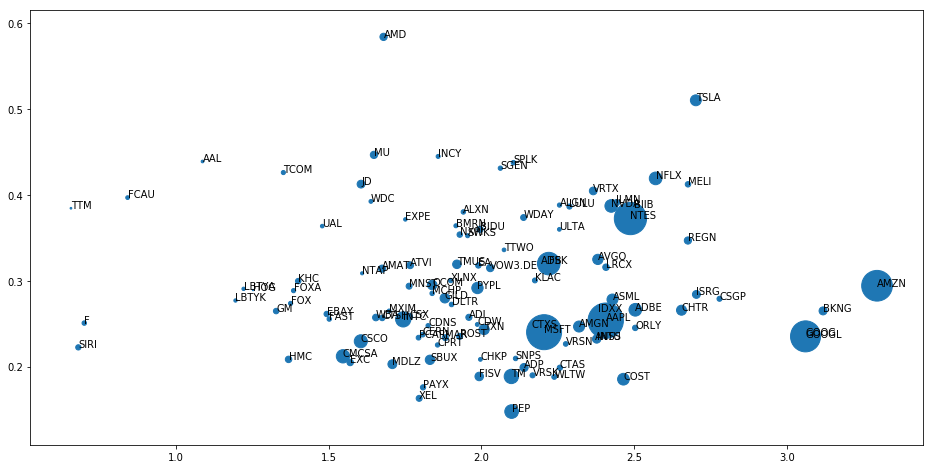

In [68]:
dfp = df[~pd.isnull(df["av"])].copy()
#dfp = df.copy()
x = np.log10(dfp["prev_close"])
z = dfp["market_cap"]
y = dfp["av"]
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y, s=z/1e9)

for i in range(len(dfp)):
    ax.annotate(dfp.iloc[i]["symbol"], (x[i], y[i]))    

### Close VS PE chart

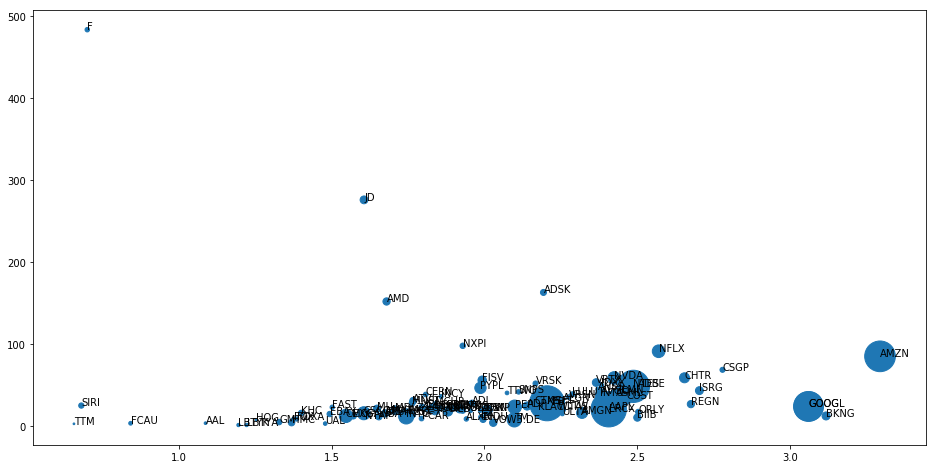

In [69]:
dfp = df[~pd.isnull(df["pe_ratio"])].copy()
dfp.reset_index(inplace=True)
#dfp = df.copy()
x = np.log10(dfp["prev_close"])
z = dfp["market_cap"]
y = dfp["pe_ratio"]
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y, s=z/1e9)

for i in range(len(dfp)):
    ax.annotate(dfp.iloc[i]["symbol"], (x[i],y[i]))    

In [71]:
df["Sector"].unique()

array(['Technology', 'Health Care', 'Consumer Services', 'Transportation',
       'Miscellaneous', 'Consumer Non-Durables', 'Consumer Durables', nan,
       'Capital Goods', 'Public Utilities', 'Finance'], dtype=object)

In [74]:
df[df["Industry"]=="Auto Manufacturing"]

,symbol,name,market_cap,close,IPOyear,Sector,Industry,trading_on,prev_close,year_low,year_high,volume,beta,pe_ratio,eps,av
73,PCAR,PACCAR,22391742591,64.65,NaN,Capital Goods,Auto Manufacturing,NASDAQ,62.27,49.11,83.41,2264502,1.26,8.90,6.870,0.2337
88,TSLA,Tesla,118991808868,645.33,2010.0,Capital Goods,Auto Manufacturing,NASDAQ,502.13,176.99,968.99,17771485,0.48,NaN,-4.920,0.5103
103,F,Ford Motor Company,20000000000,-1.00,1956.0,Capital Goods,Auto Manufacturing,NYSE,5.03,3.96,10.56,230390259,1.16,483.00,0.010,0.2507
104,GM,General Motors Com...,30000000000,-1.00,2010.0,Capital Goods,Auto Manufacturing,NYSE,21.32,14.33,41.90,19991250,1.30,4.55,4.570,0.2647
105,HOG,Harley-Davidson In...,2000000000,-1.00,1986.0,Capital Goods,Auto Manufacturing,NYSE,17.92,14.31,41.40,5228044,1.15,7.06,2.680,0.2892
106,HMC,Honda Motor Co Ltd...,42000000000,-1.00,1978.0,Capital Goods,Auto Manufacturing,NYSE,23.41,19.38,29.44,1007072,1.14,3.88,5.790,0.2084
107,TM,Toyota Motor Corp ...,205000000000,-1.00,1999.0,Capital Goods,Auto Manufacturing,NYSE,125.22,108.01,145.41,356475,0.89,7.33,16.360,0.1885
108,TTM,Tata Motors Limite...,3000000000,-1.00,2004.0,Capital Goods,Auto Manufacturing,NYSE,4.55,4.17,17.14,1864405,1.62,2.44,1.935,0.3845
109,FCAU,Fiat Chrysler Automobiles,14000000000,-1.00,2014.0,Capital Goods,Auto Manufacturing,NYSE,6.97,6.00,16.69,3422021,NaN,3.10,NaN,0.3969
110,VOW3.DE,Volkswagen,55000000000,-1.00,1998.0,Capital Goods,Auto Manufacturing,Other,106.84,79.38,187.74,614197,1.54,3.81,26.620,0.3149


In [73]:
df["Industry"].unique()

array(['Computer Software: Prepackaged Software', 'Semiconductors',
       'Major Pharmaceuticals', 'Industrial Specialties',
       'Computer Software: Programming, Data Processing',
       'Catalog/Specialty Distribution', 'Air Freight/Delivery Services',
       'Biotechnology: Biological Products (No Diagnostic Substances)',
       'Computer Manufacturing', 'Industrial Machinery/Components',
       'EDP Services', 'Business Services', 'Television Services',
       'Apparel', 'Computer Communications Equipment',
       'Automotive Aftermarket', 'Department/Specialty Retail Stores',
       'Railroads', nan, 'Transportation Services',
       'RETAIL: Building Materials', 'Broadcasting',
       'Biotechnology: In Vitro & In Vivo Diagnostic Substances',
       'Biotechnology: Laboratory Analytical Instruments',
       'Biotechnology: Commercial Physical & Biological Resarch',
       'Other Specialty Stores', 'Electronic Components',
       'Hotels/Resorts', 'Packaged Foods',
       'Beve